In [1]:
from scipy.optimize import minimize
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
%run 2.Hicks_Henne_NEW_Final.ipynb
%run 3.Xfoil_runner_extract_value.ipynb

In [2]:
model = joblib.load('model__14_mae.joblib')
scaler = joblib.load('scaler_file__14_mae.joblib')

In [3]:
# Save the current directory
original_directory = os.getcwd()

# Navigate to another folder
os.chdir(original_directory + '\\Deformed_foils')

In [4]:
airfoil_name = '0rig_NACA0012'

CL_org, CD_org = Xfoil_runner(alpha, Re, n_iter, airfoil_name)

print(CL_org, CD_org)

0.5572 0.00848


In [5]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]

In [6]:
def objective_function(design_parameters):
    design_parameters = design_parameters.reshape(1,8)
    design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
    design_parameters = scaler.transform(design_parameters)
    
    predictions = model.predict(design_parameters)
    CL = predictions[0, 0]
    CD = predictions[0, 1]
    
    return -CL

def CD_constraint(design_parameters):
    design_parameters = design_parameters.reshape(1,8)
    design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
    design_parameters = scaler.transform(design_parameters)
    
    predictions = model.predict(design_parameters)
    CL = predictions[0, 0]
    CD = predictions[0, 1]  
    
    return CD_org - CD
    
def area_constraint(design_parameters):
    design_parameters = np.array(design_parameters).reshape((1, 8))
    i = 0
    y_mod = hicks_henne_overall(x, y , n, design_parameters, i, w, xM)
    polygon1 = Polygon(zip(x, y))
    area_orig = polygon1.area
    polygon2 = Polygon(zip(x, y_mod))
    area_mod = polygon2.area
    return area_orig - area_mod


In [7]:
bounds = [(-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit), (-limit, limit) ]
#scale
initial_guess = np.full(8, 0.00)

In [8]:
from shapely.geometry import Polygon
constraints = [{'type': 'eq', 'fun': CD_constraint},{'type': 'eq', 'fun': area_constraint}]
# constraints = [{'type': 'ineq', 'fun': CD_constraint}]
result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

optimal_design_parameters = result.x

1/1 [==============================] - 0s 27ms/step


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


1/1 [==============================] - 0s 25ms/step


In [9]:
if result.success:
    print("Optimization successful!")
else:
    print("Optimization failed. Message:", result.message)

Optimization successful!


In [10]:
optimal_design_parameters = np.array(optimal_design_parameters).reshape((1, 8))
optimal_design_parameters_df = pd.DataFrame(optimal_design_parameters, columns=feature_names)
optimal_design_parameters_scaled = scaler.transform(optimal_design_parameters_df)
Optimized = model.predict(optimal_design_parameters_scaled)
CL_opt = Optimized[0, 0]
CD_opt = Optimized[0, 1]
optimal_efficiency = CL_opt/CD_opt
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient:", CL_opt )
print("Optimal Drag Coefficient:", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)

1/1 [==============================] - 0s 25ms/step
Optimal Design Parameters: [[0.01194097 0.01145708 0.00259492 0.011851   0.00468562 0.01175148
  0.01163778 0.00905454]]
Optimal Lift Coefficient: 0.865122
Optimal Drag Coefficient: 0.008480957
Optimal Aerodynamic Efficiency: 102.0076


In [11]:
optimal_design_parameters

array([[0.01194097, 0.01145708, 0.00259492, 0.011851  , 0.00468562,
        0.01175148, 0.01163778, 0.00905454]])

In [12]:
i = 0

In [13]:
y_opt = hicks_henne_overall(x, y , n, optimal_design_parameters, i, w, xM)

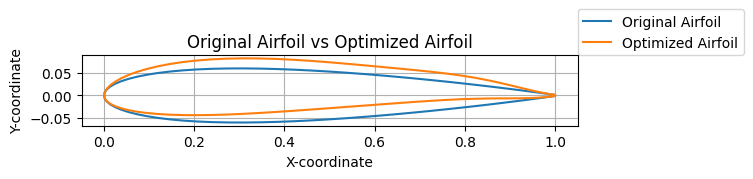

In [14]:
plt.plot(x, y, label = "Original Airfoil")
plt.plot(x, y_opt, label = "Optimized Airfoil")
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Original Airfoil vs Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend(loc=(1,1))
plt.grid()

Text(0, 0.5, 'Y-coordinate')

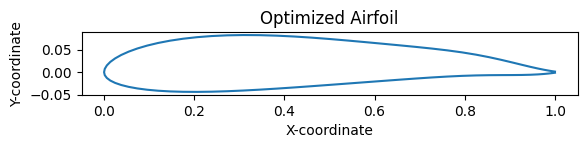

In [15]:
plt.plot(x,y_opt)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
# plt.grid()

In [16]:
df_opt = pd.DataFrame({'x': x, 'y_modified': y_opt})
path = "Optimized_airfoil_2.dat"
df_opt.to_csv(path, index=False, sep=' ')

In [17]:
airfoil_name = 'Optimized_airfoil_2'

CL, CD = Xfoil_runner(alpha, Re, n_iter, airfoil_name)

print(CL, CD)

0.8559 0.00815


In [18]:
print('Surrogate model optimization:')
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient(Surrogate model prediction):", CL_opt )
print("Optimal Drag Coefficient(Surrogate model prediction):", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)
print("Lift Coefficient for Optimal Design Parameter from XFOIL:", CL )
print("Drag Coefficient for Optimal Design Parameter from XFOIL:", CD)
Opt_eff = CL/CD
print("Optimal Aerodynamic Efficiency from XFOIL:", Opt_eff)

Surrogate model optimization:
Optimal Design Parameters: [[0.01194097 0.01145708 0.00259492 0.011851   0.00468562 0.01175148
  0.01163778 0.00905454]]
Optimal Lift Coefficient(Surrogate model prediction): 0.865122
Optimal Drag Coefficient(Surrogate model prediction): 0.008480957
Optimal Aerodynamic Efficiency: 102.0076
Lift Coefficient for Optimal Design Parameter from XFOIL: 0.8559
Drag Coefficient for Optimal Design Parameter from XFOIL: 0.00815
Optimal Aerodynamic Efficiency from XFOIL: 105.01840490797547


In [19]:
print("Error%")
print("Lift Coefficient Error:", abs((CL_opt-CL)*100/CL))
print("Drag Coefficient Error:", abs((CD_opt-CD)*100/CD))
print("Optimal Aerodynamic Efficiency Error:", abs((Opt_eff-optimal_efficiency)*100/Opt_eff))

Error%
Lift Coefficient Error: 1.0774646856640255
Drag Coefficient Error: 4.06081936110749
Optimal Aerodynamic Efficiency Error: 2.8669317855861753


In [20]:
Org_Eff = CL_org/CD_org
print("Improvement in Efiiciency")
print("Lift and Drag Coefficient of Original Airfoil:", CL_org , CD_org)
print("Efiiciency of Original Airfoil:", CL_org/CD_org)
print("Lift and Drag Coefficient of Optimized Airfoil:", CL ,CD)
print("Efiiciency of Optimized Airfoil:", Opt_eff)
print("Improvement in Efiiciency:", ((Opt_eff-Org_Eff)*100/Org_Eff),"%")

Improvement in Efiiciency
Lift and Drag Coefficient of Original Airfoil: 0.5572 0.00848
Efiiciency of Original Airfoil: 65.70754716981132
Lift and Drag Coefficient of Optimized Airfoil: 0.8559 0.00815
Efiiciency of Optimized Airfoil: 105.01840490797547
Improvement in Efiiciency: 59.827005315798985 %


In [21]:
# Return to the original directory
os.chdir(original_directory)
opt_row = optimal_design_parameters.reshape(8)
opt_row = np.append(opt_row,CL)
opt_row = np.append(opt_row,CD)
opt_row

array([0.01194097, 0.01145708, 0.00259492, 0.011851  , 0.00468562,
       0.01175148, 0.01163778, 0.00905454, 0.8559    , 0.00815   ])

In [22]:
new_dataset = pd.read_excel('new_dataset.xlsx')
new_dataset.drop(columns=['Unnamed: 0'], inplace=True)
new_dataset

,x1,x2,x3,x4,x5,x6,x7,x8,CL,CD
0,0.0084,0.0104,-0.0033,-0.0033,-0.0086,0.0015,-0.0019,-0.0027,0.5294,0.00733
1,-0.0045,-0.0035,0.0057,0.0062,0.0106,-0.0060,0.0101,0.0037,0.6747,0.00947
2,-0.0093,0.0038,-0.0083,-0.0113,0.0030,-0.0028,-0.0093,0.0085,0.4693,0.00959
3,0.0019,-0.0093,0.0067,0.0025,-0.0012,0.0077,0.0026,-0.0092,0.5034,0.00928
4,0.0045,0.0017,0.0026,0.0050,-0.0039,0.0034,-0.0087,0.0105,0.6249,0.00916
...,...,...,...,...,...,...,...,...,...,...
170,0.0110,0.0077,-0.0032,-0.0118,0.0111,-0.0114,0.0064,0.0104,0.6251,0.00798
171,0.0115,0.0120,-0.0063,-0.0128,0.0070,-0.0113,0.0099,0.0118,0.6383,0.00789
172,0.0125,0.0107,-0.0070,-0.0109,0.0083,-0.0120,0.0086,0.0113,0.6353,0.00795
173,0.0118,0.0115,-0.0064,-0.0120,0.0076,-0.0127,0.0104,0.0110,0.6356,0.00791


In [23]:
l = len(new_dataset)
l

175

In [24]:
new_dataset.loc[l] = opt_row
new_dataset

,x1,x2,x3,x4,x5,x6,x7,x8,CL,CD
0,0.008400,0.010400,-0.003300,-0.003300,-0.008600,0.001500,-0.001900,-0.002700,0.5294,0.00733
1,-0.004500,-0.003500,0.005700,0.006200,0.010600,-0.006000,0.010100,0.003700,0.6747,0.00947
2,-0.009300,0.003800,-0.008300,-0.011300,0.003000,-0.002800,-0.009300,0.008500,0.4693,0.00959
3,0.001900,-0.009300,0.006700,0.002500,-0.001200,0.007700,0.002600,-0.009200,0.5034,0.00928
4,0.004500,0.001700,0.002600,0.005000,-0.003900,0.003400,-0.008700,0.010500,0.6249,0.00916
...,...,...,...,...,...,...,...,...,...,...
171,0.011500,0.012000,-0.006300,-0.012800,0.007000,-0.011300,0.009900,0.011800,0.6383,0.00789
172,0.012500,0.010700,-0.007000,-0.010900,0.008300,-0.012000,0.008600,0.011300,0.6353,0.00795
173,0.011800,0.011500,-0.006400,-0.012000,0.007600,-0.012700,0.010400,0.011000,0.6356,0.00791
174,0.010700,0.011400,-0.007900,-0.011700,0.006600,-0.011500,0.009100,0.012500,0.6318,0.00793


In [25]:
# new_dataset.to_excel('new_dataset.xlsx')